# Pong

### Setup

In [17]:
%load_ext autoreload
%autoreload 2
import sys
import os

cwd = os.getcwd()
src_path = os.path.join(cwd, 'src')
print(f'adding {src_path} to path')
if src_path not in sys.path:
    sys.path.append(src_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
adding /Users/jollyjerr/code/@school/pong/src to path


## Problem Analysis

This project aims to develop a deep learning model capable of playing the classic Atari game, "Pong." This goal will be tackled using reinforcement learning (RL), a specialized field within machine learning dedicated to solving problems that involve an agent learning to make decisions in an environment to maximize a reward.

I'll be leveraging the Gymnasium framework (https://gymnasium.farama.org/) to streamline the development process. Gymnasium provides a high-level, Pythonic API that significantly simplifies the complexities of setting up and interacting with reinforcement learning environments. Specifically, this project will focus on training a model to interpret a sequence of frames from the Pong video game and translate that understanding into a series of actions that lead to the highest possible in-game score.

### Data

This project presents a unique challenge: the "data" – a sequence of video game frames – is generated in real-time as the model interacts with the game. To gain an initial understanding of this dynamic data, I developed a script to play several games using random actions and recorded the output provided by the Gymnasium framework.

See the script [here](./src/collect_eda_data.py).

## EDA

The full EDA process can be found [in this notebook](./notebooks/eda.ipynb).

First, we explored the data to understand the size of the observation space (`(210, 160, 3)`) and the action space (`Discrete(6)`). This means that in each frame of the game, our model has `210 x 160` pixels to observe and can take one of six actions. After taking an action, the next frame will provide a discrete reward reflecting whether the agent scored (`1`), the opponent scored (`-1`), or nothing happened (`0`).


After understanding the shape of the data exposed by the Gymnasium framework, we used this [script](./src/collect_eda_data.py) to generate a 5-episode dataset (an "episode" is a game of Pong) with a dummy agent making random decisions each frame. Highlights from this analysis can be seen here:


Total number of frames collected: 4362
Total number of episodes collected: 5

Minimum episode length: 783
Maximum episode length: 1000
Mean episode length: 872.40
Median episode length: 843.0


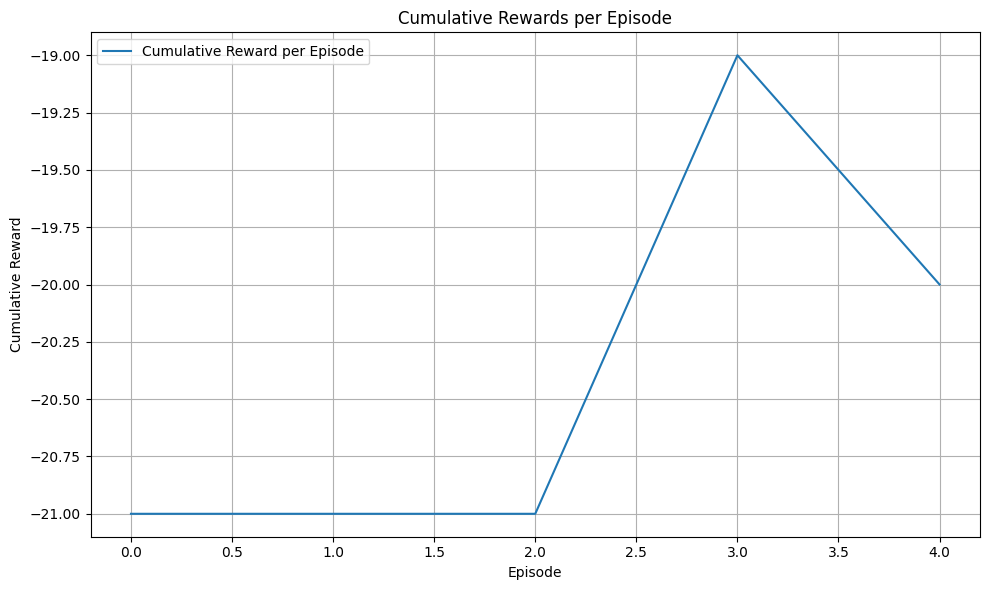

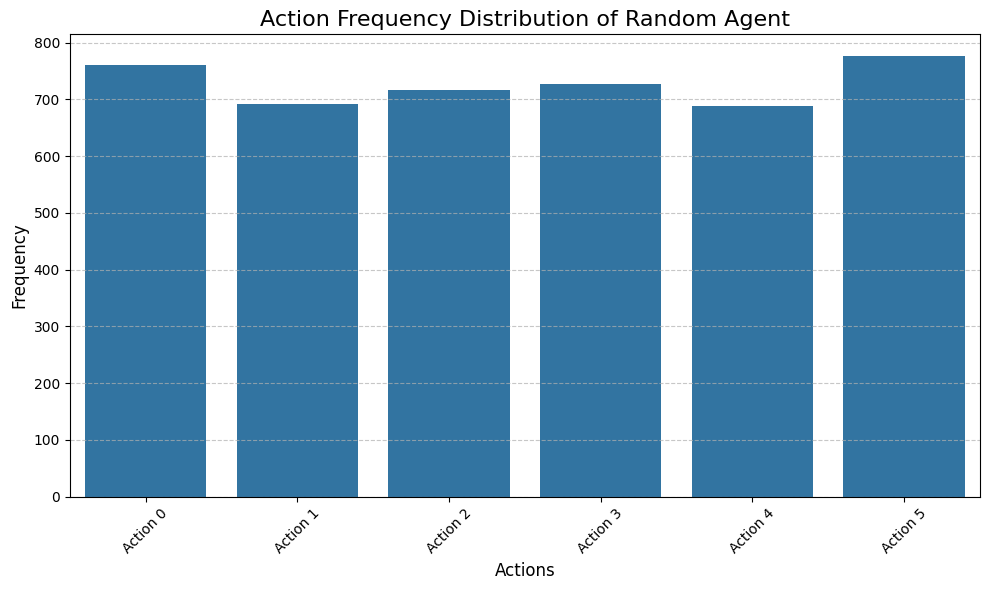

In [18]:
import os
import project_helpers as ph

file_path = os.path.join(os.getcwd(), 'data/eda.h5')
ph.eda_dataset_highlights(file_path)

The primary takeaway was that a random agent will receive a reward of about `-20` (20 points scored against them, 1 point scored by the agent) and will survive for around 850 frames. A trained agent can improve in two ways: by surviving for more frames or by scoring more points.

We then inspected the frame data, with these highlights:

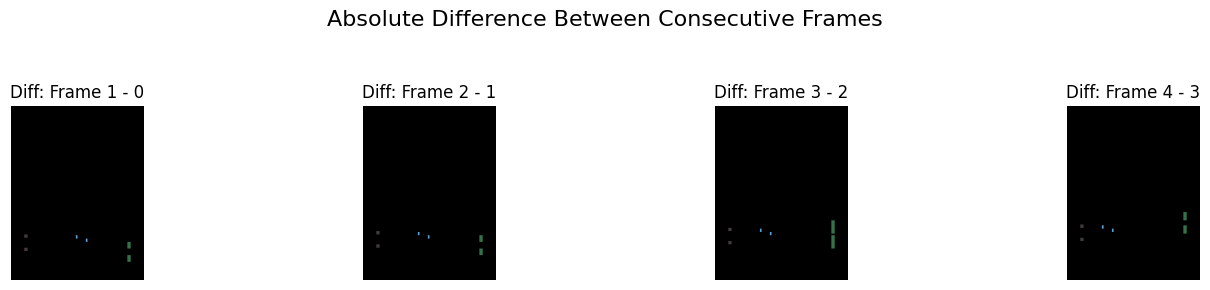

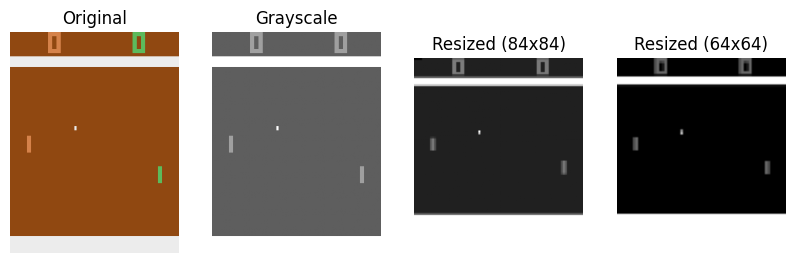

In [19]:
ph.eda_frame_highlights(file_path)

From these visualizations, you can see that frames represent a substantial gap in time during gameplay, and the observation space can be resized and grayscaled without much loss of clarity.

### Results

Results are outlined above, but the key actionable takeaways were:

- **Model success can be measured** using an average cumulative reward higher than `-21` or an average episode length longer than `872` frames.
- **The observation space can be resized** and grayscaled in a preprocessing step to reduce the computational requirements of training.

## Model Architecture

In order to build a somewhat successful model, I focused on a single model architecture: **Deep Q-Network**.

This architecture uses deep neural networks to approximate a "Q-table", a mapping of observations to ideal actions, for the entirety of possible game states. There are two models being trained: an "online" network and a "target" network. They both use the same CNN architecture for learning from images, but the online network updates every frame, while the target network is only updated periodically.

DQN also addresses local optima instability by storing previous observations in a memory buffer and randomly sampling from them along with new observations during training. This preserves a sense of long-term memory for highly rewarding past actions.

When the model is training, it starts by exploring the environment with random actions to learn what is rewarding. This exploration gradually decays over time as the model learns.

Observations are also grouped into small stacks of frames, allowing the model to learn from velocity and motion cues.

In this project, I started with a very minimal DQN implementation and exposed constructor arguments to enable **hyperparameter tuning** for discovering the optimal configuration. This model is [here](./src/dqn_a.py), and the training notebook can be found [here](./notebooks/model_architecture.ipynb).

### Preprocessing

From the EDA section, we know that it helps our model learn if frames are converted to grayscale and resized. I trained using both `64x64` and `84x84` frame sizes.

### Hyperparameter Tuning

There are many hyperparameters to tune with this model architecture. Here are key snippets of code showing what was optimized and tested over multiple training rounds:

```py
frame_size = [64, 84]

grid = {
    "learning_rate": [1e-4, 5e-4],
    "fc_units": [256, 512],
    "gamma": [0.95, 0.99]
}

conv_layers = [
    {"out_channels": 32, "kernel_size": 5, "stride": 2},
    {"out_channels": 64, "kernel_size": 4, "stride": 2},
    {"out_channels": 64, "kernel_size": 3, "stride": 2},
]

EPSILON_START = 10
EPSILON_END = 10
EPSILON_DECAY = 10
BATCH_SIZE = 10
TARGET_UPDATE = 10
MEMORY_SIZE = 10
MIN_MEMORY = 10
MAX_EPISODES = 10
```

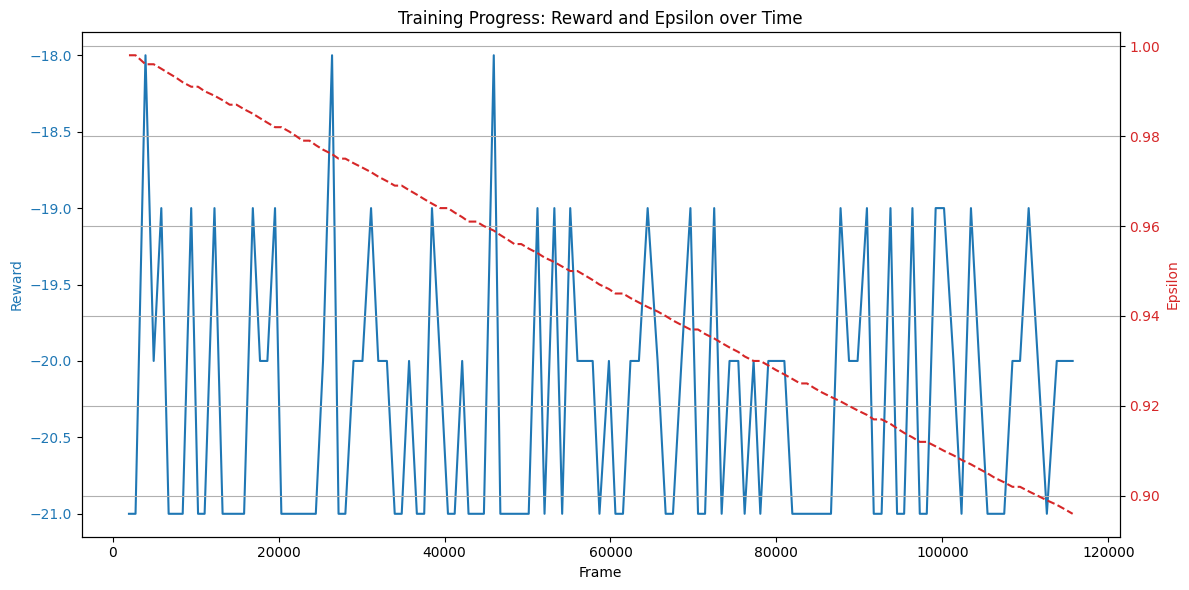

In [20]:
ph.training_sample('data/early_example.csv')

You can see this training run above was performing about as poorly as a random action model. This was due to multiple factors, but mainly due to **updating the target network too often** with a low target update frequency.

Hyperparameter tuning was challenging because of the time and computational intensity of training these models. We used epsilon slope and cumulative reward to determine how well the model was learning.

These values resulted in a model that successfully improved over time during training:

```py
frame_size = 84  # Reducing the images to 64x64 resulted in poor CNN performance and very slow training progress

learning_rate = 1e-4
fc_units = 512
gamma = 0.99

conv_layers = [
    {"out_channels": 32, "kernel_size": 8, "stride": 4},
    {"out_channels": 64, "kernel_size": 4, "stride": 2},
    {"out_channels": 64, "kernel_size": 3, "stride": 1},
]

EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 1000000
BATCH_SIZE = 16
TARGET_UPDATE = 10000
MEMORY_SIZE = 25000
MIN_MEMORY = 10000
MAX_EPISODES = 10000
```

### Architecture Changes

My initial implementation in [dqn_a](./src/dqn_a.py) was learning and would have likely eventually performed better than a random agent, but it was extremely slow to learn. In [dqn_b](./src/dqn_b.py), I made a few changes while exploring ways to improve the model, but the key change was **explicit Kaiming initialization**. This prevents vanishing gradients and the Dying ReLU problem when using ReLU activation functions.

While I didn't fully understand the implications of this fix at the time, it dramatically improved the model's training speed and resulted in a model that wins on average after three hours of training on a GPU.


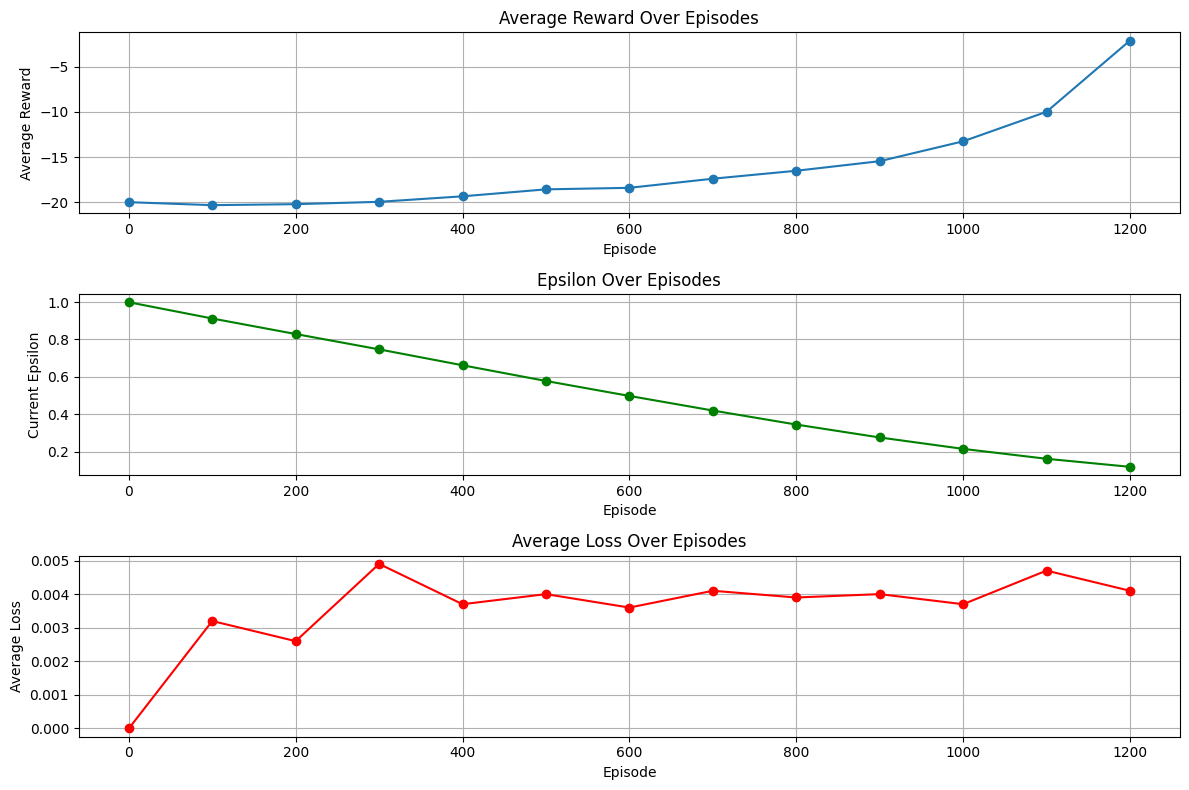

In [21]:
ph.final_training_report()

## Results and Analysis

## Conclusion

### References

[1] MG Bellemare, Y Naddaf, J Veness, and M Bowling. “The arcade learning environment: An evaluation platform for general agents.” Journal of Artificial Intelligence Research (2012).

[2] Machado et al. “Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents” Journal of Artificial Intelligence Research (2018) URL: https://jair.org/index.php/jair/article/view/11182

[3] Jesse Farebrother and Pablo Samuel Castro “CALE: Continuous Arcade Learning Environment” Advances in Neural Information Processing Systems (NeurIPS 2024) URL: https://arxiv.org/abs/2410.23810

[4] Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015). https://doi.org/10.1038/nature14236